## How much variance does each pc explain for its cluster's genes?

I'm concerned that pcqtls are being driven by the expression of individual genes. 

Stephen suggests the following: 

"We should plot how much variance is explained by each PCqtl and see if there are some where it is imbalanced across genes or pretty similar. You could do a scatterplot of variance explained for gene 1 and gene 2 where gene 1 and 2 are the genes where the most variance is explained (for multi gene clusters beyond 2) "


qtl variance is the suqared effect size, if the data is standardized. I could also look look at the gene variance explianed by the PC itself

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.auto import tqdm  # for notebooks
import ast
from scipy.stats import linregress
import matplotlib.patches as patches

load in data

In [21]:
# load nominal p value dfs

# load in e nominal
def load_e_nominal(path):
    e_nominal_df = pd.read_parquet(path)
    e_nominal_df['cluster_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[0]
    e_nominal_df['egene_id'] = e_nominal_df['phenotype_id'].str.split('_e_').str[1]
    return e_nominal_df

e_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    e_nominal_dfs.append(load_e_nominal(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{chr_id}.parquet'))

e_nominal_df = pd.concat(e_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

In [22]:
def load_pc_nominal(path):
    pc_nominal_df = pd.read_parquet(path)
    pc_nominal_df['cluster_id'] = pc_nominal_df['phenotype_id'].str.split('_pc').str[0]
    pc_nominal_df['pc_num'] = pc_nominal_df['phenotype_id'].str.split('_pc').str[1]
    return pc_nominal_df

pc_nominal_dfs=[]
for chr_id in tqdm(range(1,23)):
    pc_nominal_dfs.append(load_pc_nominal(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.cis_qtl_pairs.chr{chr_id}.parquet'))
pc_nominal_df = pd.concat(pc_nominal_dfs)

  0%|          | 0/22 [00:00<?, ?it/s]

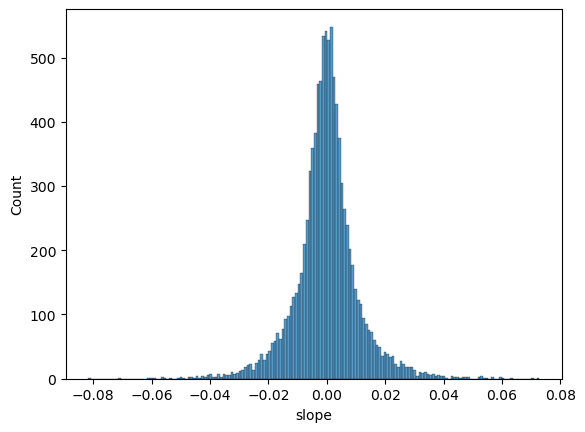

In [9]:
# Some of the variances are >100%. This would happen if the slope values are not bounded by [-1,1]
# Dan suggests this could be the case if the genotype or expression were not normalized. 
# I normalized the expression and this fixed it!


sns.histplot(pc_nominal_df.sample(10000), x='slope')
plt.show()

In [124]:
overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')

In [125]:
# label cluster-variant pairs
overlap_df['var_cluster'] = overlap_df['lead_variant_id'] + '_' + overlap_df['cluster_id']
pc_nominal_df['var_cluster'] = pc_nominal_df['variant_id'] + '_' + pc_nominal_df['cluster_id']
e_nominal_df['var_cluster'] = e_nominal_df['variant_id'] + '_' + e_nominal_df['cluster_id']

# set e_nominal to be index based on variant-cluster pairs
e_nominal_df_cid = e_nominal_df.set_index('var_cluster')


### lead variant only

start with just lead variants from susie (this is not exactly correct but will work for a first pass)

In [12]:
pc1qtl_vars = overlap_df[overlap_df['cs_full_id'].str.contains('pc1')]['var_cluster']

In [16]:
# get the eqtl effects for the pcqtl lead variants 
pc1qtl_vars_e_nominal = e_nominal_df[e_nominal_df['var_cluster'].isin(pc1qtl_vars)]
pc1qtl_vars_e_nominal.reset_index(inplace=True)
# effect size/percent varaince explined
pc1qtl_vars_e_nominal['effect_size'] = (pc1qtl_vars_e_nominal['slope']**2) * 100

/local/scratch/klawren/slrmtmp.42790837/ipykernel_27259/1359025870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc1qtl_vars_e_nominal['effect_size'] = (pc1qtl_vars_e_nominal['slope']**2) * 100


In [19]:
# keep only the largest and 2nd largest effect size for each cluster 
plot_df = pc1qtl_vars_e_nominal.groupby('cluster_id').apply(lambda x: x.nlargest(2, 'effect_size')).reset_index(drop=True)

# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cluster_id')['effect_size'].rank("dense", ascending=False)

# Pivot the DataFrame
plot_df = plot_df.pivot(index='cluster_id', columns='rank', values='effect_size')

# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

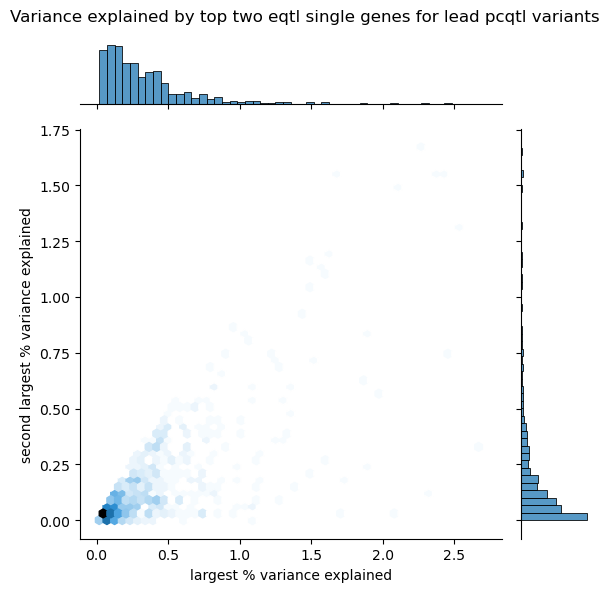

In [75]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex', gridsize=50, marginal_kws=dict(bins=50))

# Set labels
jplot.set_axis_labels('largest % variance explained', 'second largest % variance explained')

plt.suptitle('Variance explained by top two eqtl single genes for lead pcqtl variants')
jplot.fig.tight_layout()
# Show the plot
plt.show()


### credible set

Rather than just taking the variance of the lead snp, I can expand to take the pip*variance for the whole credible set

In [21]:
# load in the susie df, so I have the pip values for the variants as well as the slopes
pc_susie_df = pd.read_csv(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.susie.txt', sep='\t', index_col=0)
pc_susie_df['var_cluster'] = pc_susie_df['variant_id'] + '_' + pc_susie_df['phenotype_id'].str.split('_pc1').str[0]
pc_susie_df['cs_id'] =  pc_susie_df['phenotype_id'].str.split('_pc1').str[0] + '_' + pc_susie_df['cs_id'].astype(str)
pc_susie_df['pc_num'] = pc_susie_df['phenotype_id'].str.split('_pc').str[-1].astype(int)

In [72]:
# get a subset of variants that ended up in credible sets
e_nominal_pcsusie_subset_df = e_nominal_df[e_nominal_df['var_cluster'].isin(pc_susie_df['var_cluster'])]

# I want to get a pip weighted variance for each egene
e_nominal_pcsusie_subset_df['var_egene_cluster'] = e_nominal_pcsusie_subset_df['variant_id'] + '_' + e_nominal_pcsusie_subset_df['phenotype_id']

# merge in the data from the susie finemapping
e_nominal_pcsusie_subset_df = pd.merge(e_nominal_pcsusie_subset_df, pc_susie_df[['cs_id', 'var_cluster', 'pip', 'pc_num']], on='var_cluster')

# pip weighted variance
e_nominal_pcsusie_subset_df['variance'] = e_nominal_pcsusie_subset_df['slope'].apply(np.square) * 100
e_nominal_pcsusie_subset_df['variance_weighted'] = e_nominal_pcsusie_subset_df['variance'] * e_nominal_pcsusie_subset_df['pip'] 

/local/scratch/klawren/slrmtmp.42790837/ipykernel_27259/592972537.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_nominal_pcsusie_subset_df['var_egene_cluster'] = e_nominal_pcsusie_subset_df['variant_id'] + '_' + e_nominal_pcsusie_subset_df['phenotype_id']


In [77]:
# group by phenotype (egene and cluster)
sum_variance_df = e_nominal_pcsusie_subset_df.groupby('phenotype_id').agg({'variance_weighted':sum, 'cluster_id':'first'})

# keep only the largest and 2nd largest effect size for each cluster 
plot_df = sum_variance_df.groupby('cluster_id').apply(lambda x: x.nlargest(2, 'variance_weighted')).reset_index(drop=True)

# Add a rank column with grouped rank numbers
plot_df['rank'] = plot_df.groupby('cluster_id')['variance_weighted'].rank("dense", ascending=False)

# Pivot the DataFrame
plot_df = plot_df.pivot(index='cluster_id', columns='rank', values='variance_weighted')

# Rename the columns for clarity
plot_df.columns = ['largest', 'second_largest']

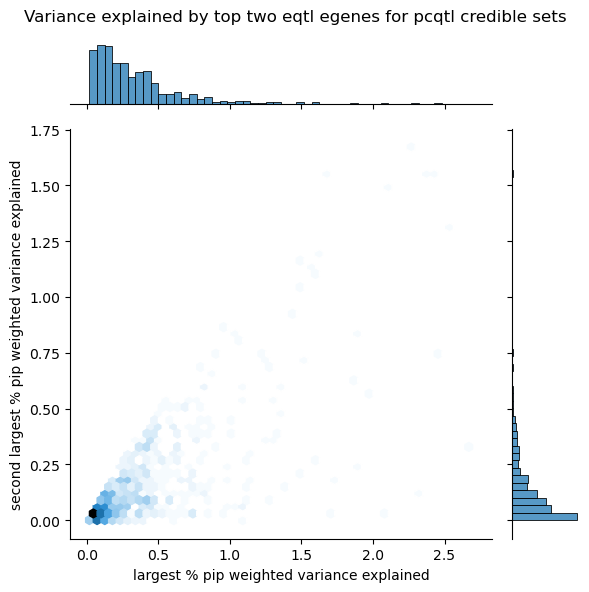

In [78]:
# Create the jointplot
jplot = sns.jointplot(data=plot_df, x='largest', y='second_largest', kind='hex', gridsize=50, marginal_kws=dict(bins=50))

# Set labels
jplot.set_axis_labels('largest % pip weighted variance explained', 'second largest % pip weighted variance explained')

plt.suptitle('Variance explained by top two eqtl egenes for pcqtl credible sets')
jplot.fig.tight_layout()
# Show the plot
plt.show()


Some of the variances are >100%. This would happen if the slope values are not bounded by [-1,1]. Dan suggests this could be the case if the genotype or expression were not normalized. 

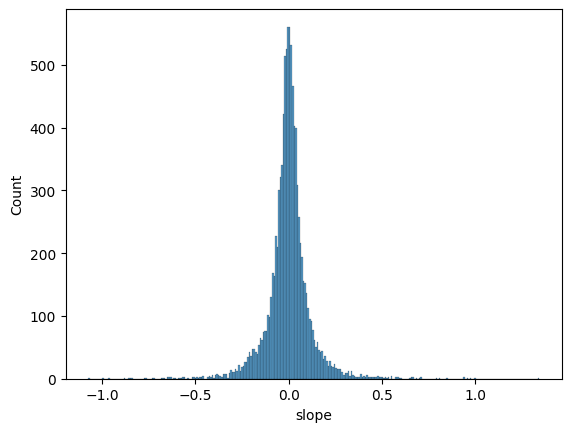

In [ ]:
sns.histplot(e_nominal_df.sample(10000), x='slope')
plt.show()

### the PCs themselves
do they explain the variance for multiple genes?

In [23]:
# start in just one tissue
tissue_id = 'Cells_Cultured_fibroblasts' # because only one cell type

pc_output_dir = config['pc_output_dir']
filtered_expression_output_dir = config['filtered_expression_output_dir']

In [24]:
# load in pc data
pc_df = pd.read_csv(f'{prefix}/{pc_output_dir}/{tissue_id}.pcs.bed', sep='\t')
# get a list of all the sample ids
sample_ids = pc_df.columns[4:]
# add a cluster id and pc number column
pc_df['cluster_id'] = pc_df['gene_id'].str.split('_pc').str[0]
pc_df['pc_id'] = pc_df['gene_id'].str.split('_pc').str[1].astype('float')
pc_df['cluster_size'] = pc_df['cluster_id'].str.split('_').apply(len)

pc_df.head()

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,pc_id,cluster_size
0,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_pc1,-0.012492,-0.032559,-0.081962,-0.080214,-0.018834,-0.061915,...,0.047541,0.004824,0.006920,0.065273,0.091484,-0.029955,-0.014282,ENSG00000187583.10_ENSG00000187961.13,1.0,2
1,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_pc2,0.005204,0.049607,0.041468,0.046362,-0.032715,-0.059307,...,-0.048064,-0.046535,-0.001738,-0.129699,-0.086610,-0.053080,-0.022042,ENSG00000187583.10_ENSG00000187961.13,2.0,2
2,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_pc1,-0.023394,-0.007673,-0.032262,0.041808,0.042320,0.009267,...,-0.031412,-0.080867,-0.062225,0.000073,-0.027968,0.049871,0.031654,ENSG00000189339.11_ENSG00000248333.8,1.0,2
3,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_pc2,0.004411,0.029045,-0.037281,-0.016904,-0.030414,0.011592,...,-0.036408,0.084067,-0.027125,0.005919,0.037338,0.017079,-0.045869,ENSG00000189339.11_ENSG00000248333.8,2.0,2
4,chr1,1724323,1745992,ENSG00000008128.22_ENSG00000215790.6_pc1,0.005625,-0.028615,-0.058112,-0.015800,0.015038,-0.003349,...,0.055570,0.043555,0.009709,-0.007426,-0.060154,0.031684,-0.034029,ENSG00000008128.22_ENSG00000215790.6,1.0,2


Text(0.5, 1.0, 'Pairwise correlations between all pcs')

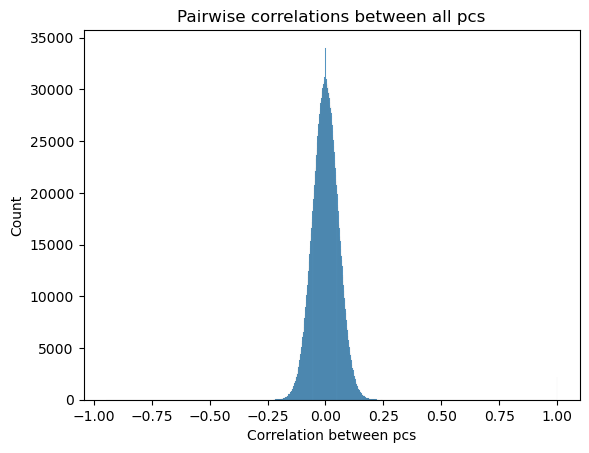

In [25]:
## qc check - are the pcs correlated to each other?
corrs = pc_df[sample_ids].transpose().corr()

sns.histplot(corrs.values.flatten())
plt.xlabel('Correlation between pcs')
plt.title('Pairwise correlations between all pcs')

In [26]:
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{filtered_expression_output_dir}/{tissue_id}.v8.normalized_expression.cluster_genes.bed', sep='\t')
# add a cluster id and pc number column
expression_df['cluster_id'] = expression_df['gene_id'].str.split('_e_').str[0]
expression_df['egene_id'] = expression_df['gene_id'].str.split('_e_').str[1]

expression_df.head()

,#chr,start,end,gene_id,GTEX-111VG,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,...,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,cluster_id,egene_id
0,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,-0.013115,-0.055819,-0.090444,-0.091985,0.004575,-0.013917,...,-0.023902,0.066875,0.031793,0.006578,0.130061,0.125158,0.007906,0.001810,ENSG00000187583.10_ENSG00000187961.13,ENSG00000187961.13
1,chr1,960586,966497,ENSG00000187583.10_ENSG00000187961.13_e_ENSG00...,-0.006866,0.003739,-0.040659,-0.036323,-0.034702,-0.085119,...,-0.053182,0.009170,-0.024076,0.004492,-0.025653,0.021175,-0.055821,-0.024654,ENSG00000187583.10_ENSG00000187961.13,ENSG00000187583.10
2,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,-0.016525,0.010553,-0.047886,0.024311,0.016909,0.014267,...,0.057456,-0.046688,-0.017291,-0.066444,0.003485,-0.001198,0.050554,-0.000734,ENSG00000189339.11_ENSG00000248333.8,ENSG00000248333.8
3,chr1,1659011,1692728,ENSG00000189339.11_ENSG00000248333.8_e_ENSG000...,-0.021630,-0.023068,-0.004732,0.043878,0.052115,0.000848,...,0.023325,-0.004544,-0.114601,-0.035045,-0.003366,-0.044418,0.030785,0.052362,ENSG00000189339.11_ENSG00000248333.8,ENSG00000189339.11
4,chr1,1724323,1745992,ENSG00000008128.22_ENSG00000215790.6_e_ENSG000...,0.022301,-0.006302,0.052893,0.030058,-0.026409,0.009420,...,-0.001885,-0.067950,-0.025478,-0.011199,0.019256,0.051944,-0.050737,0.053034,ENSG00000008128.22_ENSG00000215790.6,ENSG00000008128.22


In [27]:
# take an example cluster
cluster_id = expression_df['cluster_id'].iloc[22]
cluster_id

'ENSG00000142615.7_ENSG00000162438.11_ENSG00000215704.9'

In [28]:
# the expression and pc values for this cluster
expression_cluster = expression_df[expression_df['cluster_id'] == cluster_id].reset_index()
pc_cluster = pc_df[pc_df['cluster_id'] == cluster_id].reset_index()

for i in range(len(expression_cluster)):
    for j in range(len(pc_cluster)):
        # pull the right data
        pc_values = pc_cluster.loc[j, sample_ids].astype('float')
        expression_values = expression_cluster.loc[i, sample_ids].astype('float')
        # get the r squared value
        slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
        print('{:.2f}% of {} variance explained by pc{}'.format((r_value**2)*100, 
                                                            expression_cluster.iloc[i]['egene_id'], 
                                                            pc_cluster.iloc[j]['pc_id']))

76.82% of ENSG00000162438.11 variance explained by pc1.0
15.82% of ENSG00000162438.11 variance explained by pc2.0
7.36% of ENSG00000162438.11 variance explained by pc3.0
82.52% of ENSG00000142615.7 variance explained by pc1.0
0.58% of ENSG00000142615.7 variance explained by pc2.0
16.90% of ENSG00000142615.7 variance explained by pc3.0
73.91% of ENSG00000215704.9 variance explained by pc1.0
23.60% of ENSG00000215704.9 variance explained by pc2.0
2.49% of ENSG00000215704.9 variance explained by pc3.0


In [29]:
# for each cluster, for each pc, pull the largest two values

# the expression and pc values for this cluster
for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
    expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
    gene_variances = []
    for i in range(len(expression_cluster)):
        # pull the right data
        pc_values = row[sample_ids].astype('float')
        expression_values = expression_cluster.loc[i, sample_ids].astype('float')
        # get the r squared value
        slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
        gene_variances.append((r_value**2)*100)
    gene_variances.sort()
    pc_df.loc[idx, 'largest_variance'] = gene_variances[-1]
    pc_df.loc[idx, 'second_largest_variance'] = gene_variances[-2]
    pc_df.loc[idx, 'total_variance'] = sum(gene_variances)

    

  0%|          | 0/2203 [00:00<?, ?it/s]

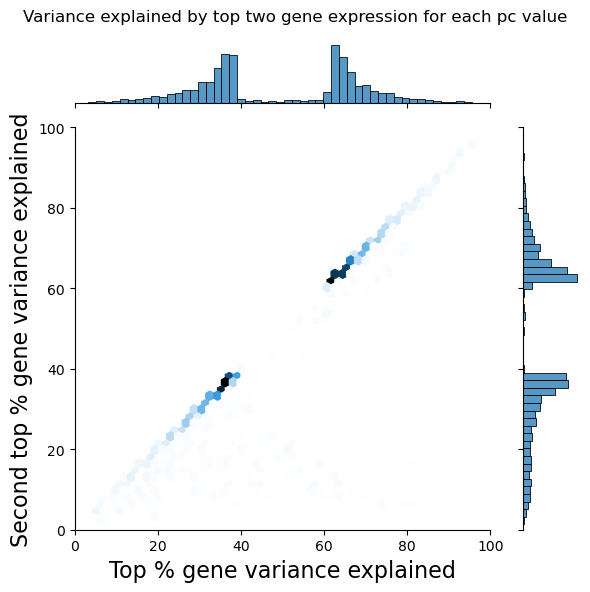

In [30]:
# Create the jointplot
jplot = sns.jointplot(data=pc_df, x='largest_variance', y='second_largest_variance', kind='hex', gridsize=50, marginal_kws=dict(bins=50))

# Set labels
jplot.set_axis_labels('Top % gene variance explained', 'Second top % gene variance explained', fontsize=16)

plt.suptitle('Variance explained by top two gene expression for each pc value')
jplot.fig.tight_layout()
jplot.ax_joint.set_xlim(0,100)
jplot.ax_joint.set_ylim(0,100)
# Show the plot
plt.show()


In [31]:
pc_df['pc_id_clip'] = pc_df['pc_id'].clip(0,4)

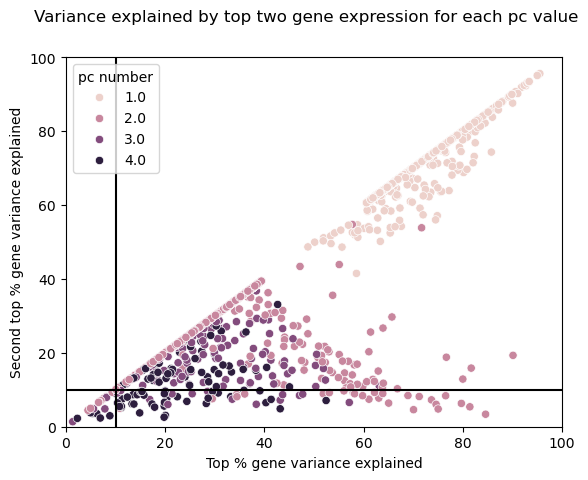

In [32]:
# Create the jointplot, broken up by pc number 
ax = sns.scatterplot(data=pc_df, x='largest_variance', y='second_largest_variance', hue='pc_id_clip')

# Set labels
ax.set_xlabel('Top % gene variance explained')
ax.set_ylabel('Second top % gene variance explained')

plt.suptitle('Variance explained by top two gene expression for each pc value')

ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.hlines(10, 0, 100, color='k')
ax.vlines(10, 0, 100, color='k')


# Show the plot
plt.legend(title='pc number')
plt.show()


In [33]:
pc_df['10_var_two_genes_filter'] = (pc_df['largest_variance']>10) & (pc_df['second_largest_variance']>10)
pc_df['20_var_two_genes_filter'] = (pc_df['largest_variance']>20) & (pc_df['second_largest_variance']>20)


# write out list of pcs that pass variance filters
pc_df.to_csv(f'{prefix}/{pc_output_dir}/{tissue_id}.pcs.variances.csv', sep='\t')

In [34]:
overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')

In [35]:
# do the pcs that pass these thresholds get more qtls?

# make a shared key for the overlap credible sets and the pcs
overlap_df['phenotype_id'] = overlap_df['cs_full_id'].str.split('_cs').str[0]
pc_df['phenotype_id'] = pc_df['gene_id']

# add on the variance explained information
overlap_df = pd.merge(overlap_df[overlap_df['orig_cs_dataset'] == 'pc_qtl'], pc_df[['largest_variance', 'second_largest_variance', 'phenotype_id', 'total_variance']], on='phenotype_id', how='outer')

# add the pc number
overlap_df['pc_num'] = overlap_df['phenotype_id'].str.split('_pc').str[-1].astype(int)



In [64]:
# count credible sets per pc
# useful to determine pc level inclusion
cs_counts = overlap_df.groupby('phenotype_id').agg({'cs_full_id':'count',
                                        'second_largest_variance':'first',
                                        'largest_variance':'first',
                                        'total_variance':'first',
                                        'pc_num':'first',
                                        'num_e_overlap':sum,
                                        'num_e_samelead':sum,
                                        })

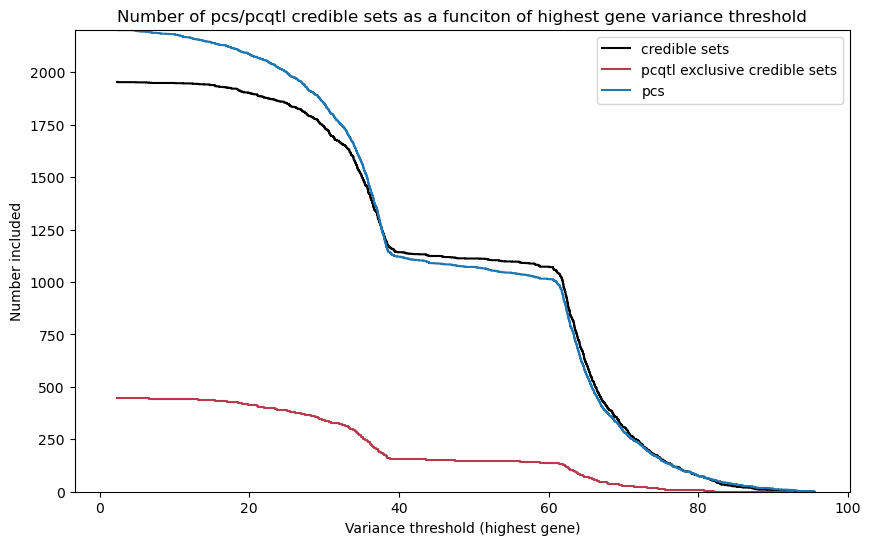

In [97]:
# plot
fig,ax = plt.subplots(figsize=(10,6))

sns.ecdfplot(data=overlap_df[overlap_df['orig_cs_dataset'] == 'pc_qtl'], x='largest_variance', complementary=True, stat='count', color='k', label='credible sets', ax=ax)
sns.ecdfplot(data=overlap_df[(overlap_df['orig_cs_dataset'] == 'pc_qtl')&(overlap_df['num_e_overlap']==0)], x='largest_variance', complementary=True, stat='count', color='#B83A4B', label='pcqtl exclusive credible sets', ax=ax)
sns.ecdfplot(data=cs_counts, x='largest_variance', complementary=True, stat='count', ax=ax, label='pcs')

ax.set_xlabel('Variance threshold (highest gene)')
ax.set_ylabel('Number included')

ax.set_title('Number of pcs/pcqtl credible sets as a funciton of highest gene variance threshold')

plt.legend()


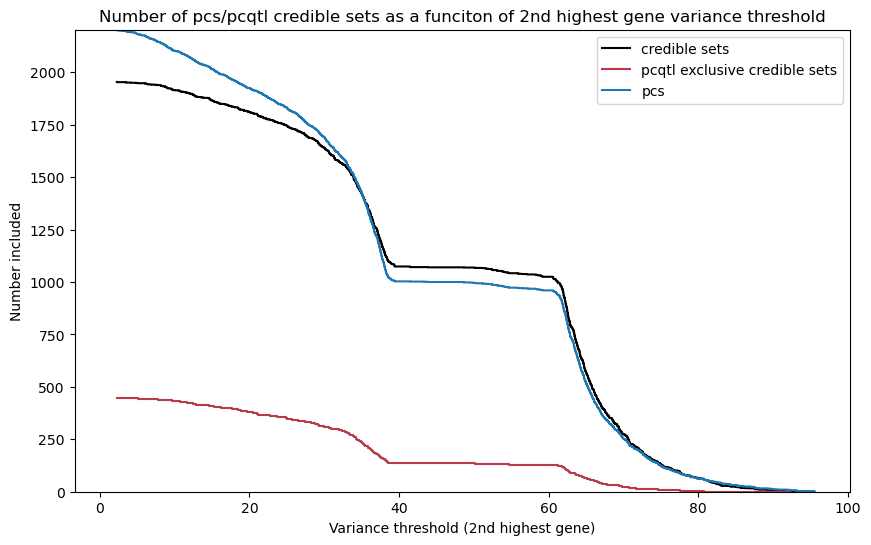

In [98]:
# plot
fig,ax = plt.subplots(figsize=(10,6))

sns.ecdfplot(data=overlap_df[overlap_df['orig_cs_dataset'] == 'pc_qtl'], x='second_largest_variance', complementary=True, stat='count', color='k', label='credible sets', ax=ax)
sns.ecdfplot(data=overlap_df[(overlap_df['orig_cs_dataset'] == 'pc_qtl')&(overlap_df['num_e_overlap']==0)], x='second_largest_variance', complementary=True, stat='count', color='#B83A4B', label='pcqtl exclusive credible sets', ax=ax)
sns.ecdfplot(data=cs_counts, x='second_largest_variance', complementary=True, stat='count', ax=ax, label='pcs')

ax.set_xlabel('Variance threshold (2nd highest gene)')
ax.set_ylabel('Number included')

ax.set_title('Number of pcs/pcqtl credible sets as a funciton of 2nd highest gene variance threshold')


plt.legend()


Text(0.5, 1.0, 'Number of pcs as a funciton of 2nd highest gene variance threshold, buy pc number')

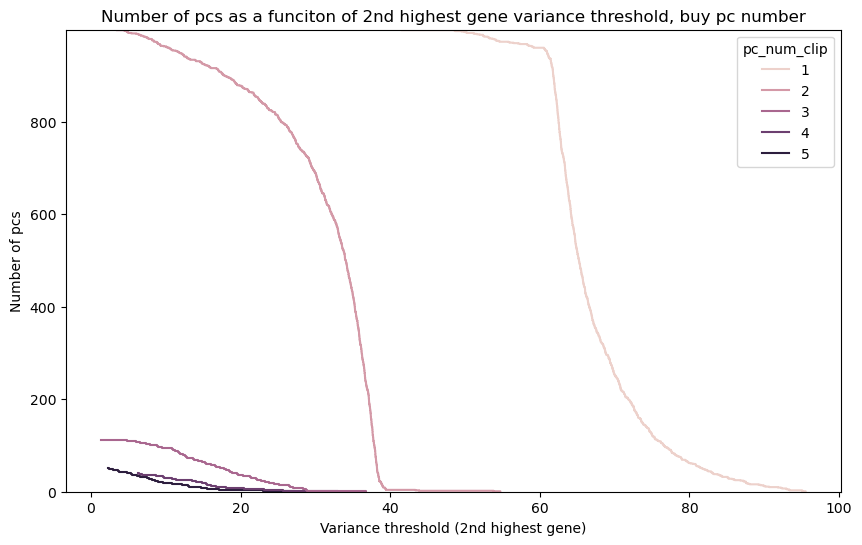

In [99]:
# broken up by pc num

cs_counts['pc_num_clip'] = cs_counts['pc_num'].clip(0,5)

# plot
fig,ax = plt.subplots(figsize=(10,6))

sns.ecdfplot(data=cs_counts, x='second_largest_variance', complementary=True, hue='pc_num_clip', stat='count', ax=ax)

ax.set_xlabel('Variance threshold (2nd highest gene)')
ax.set_ylabel('Number of pcs')

ax.set_title('Number of pcs as a funciton of 2nd highest gene variance threshold, buy pc number')
